# Hawkes process

## Introduction

**Hawkes processes** are specific stochastic processes derived from Poisson processes. They are designed to capture short-term variations and self-correlated behavior in the phenomena they model. Two well-known applications of this framework include high-frequency stock trading in finance and the temporal and intensity distribution of earthquakes.
This project focuses primarily on financial applications, but the notebook is intended to be general enough for earthquake modeling as well.

The notebook is structured into three parts:
- The first part motivates the use of Hawkes processes.
- The second part develops the theory of Hawkes processes, without revisiting the general theory of stochastic processes (as this is below the scope here).
- The final part implements a classical parameter estimation method to apply Hawkes processes in finance

## Part 1 : Motivation

### example 1 : Earthquakes

Let us begin with an example. Given a specific location in the world, two key characteristics define the earthquakes occurring there: the time of occurrence and their intensity (primarily measured on the Richter scale). Therefore, if we aim to construct a stochastic process modeling seismic activity at this location, we consider a process of the form:
$$
(I_t)_{t \in \mathbb{R}_+}, \quad \text{valued in } \mathbb{R}.
$$
We choose $\mathbb{R}_+$ rather than $\mathbb{R}$ for the index set of the process because it aligns with reality—all measurements begin at a certain time. The process takes values in $\mathbb{R}$ due to the Richter's scale defined as $log_{10}(I_{true})$.


In the following code, we use data from the **U.S. Geological Survey (USGS)** via their [FDSN Event Web Service](https://earthquake.usgs.gov/fdsnws/event/1/query). This dataset includes earthquakes that occurred within a 50 km radius of Los Angeles over a period of more than one year.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import HawkesPyLib.inference as hi
import datetime as dt

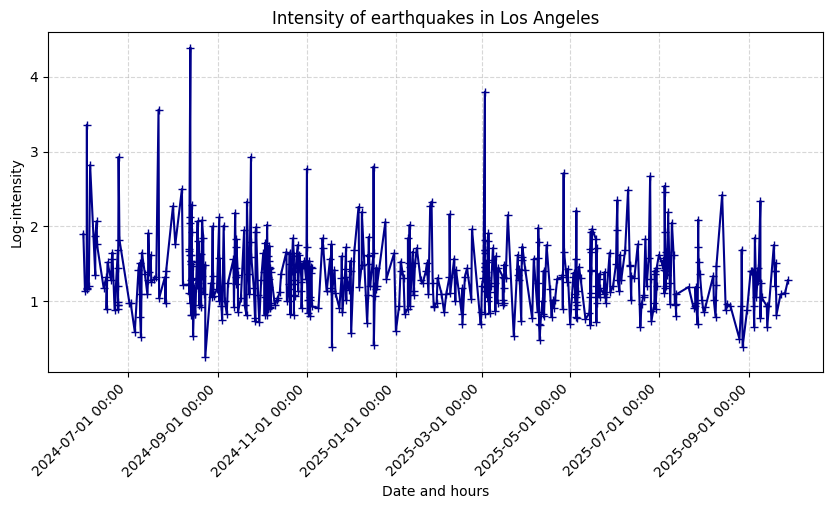

In [2]:

file_path = "data/los_angeles_earthquakes.csv"
data = pd.read_csv(file_path, usecols=["time", "mag"])


data["time"] = pd.to_datetime(data["time"], utc=True) 


fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data["time"], data["mag"], '+-', color='darkblue')


fig.autofmt_xdate(rotation=45) 
date_form = mdates.DateFormatter('%Y-%m-%d %H:%M') 
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel("Date and hours")
ax.set_ylabel("Log-intensity") 
ax.set_title("Intensity of earthquakes in Los Angeles")
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

we can zoom on the last 10 earthquakes to see what happend : 

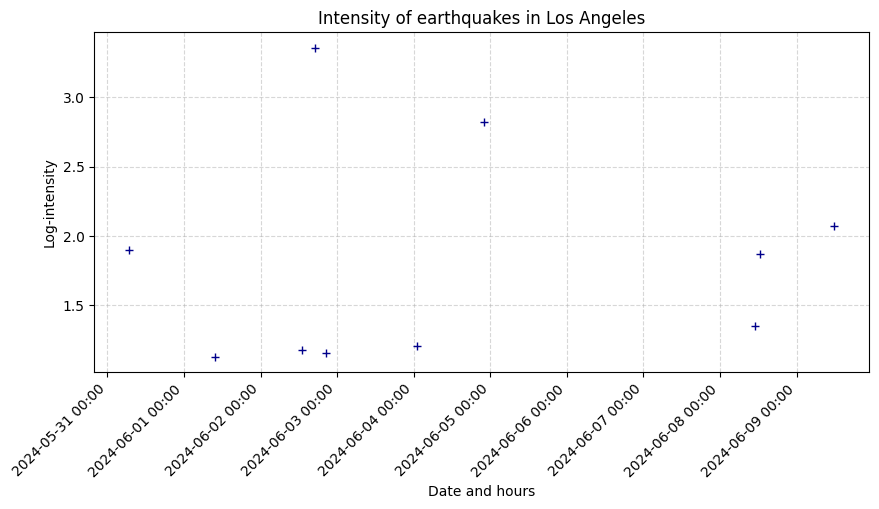

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data["time"][:10], data["mag"][:10], '+', color='darkblue')


fig.autofmt_xdate(rotation=45) 

date_form = mdates.DateFormatter('%Y-%m-%d %H:%M') 
ax.xaxis.set_major_formatter(date_form)


ax.set_xlabel("Date and hours")
ax.set_ylabel("Log-intensity") 
ax.set_title("Intensity of earthquakes in Los Angeles")
ax.grid(True, linestyle='--', alpha=0.5)

plt.show()

To model the occurrence of earthquakes, we use **Poisson processes**, as the second graph shows that earthquake events can be represented as discrete points in time. Without considering intensity, a **non-homogeneous Poisson process** is sufficient to describe their occurrence. Subsequently, we will explore how to incorporate a mark for the intensity distribution into this model.


### Example 2 : log-return in financial stocks

Financial stocks are primarily studied because analysts and traders seek to predict future prices using historical data (though traders also rely on many other sources of information, this is the simplest to illustrate in an example). There are striking similarities between **log-returns** (defined as \(\frac{dS_t}{S_t}\)) and **white noise**. As a result, asset prices often resemble **Brownian motion**.

In the following, we display the price of Bitcoin in US dollars (USDT) at one-minute intervals. The data is retrieved from the **Binance API** ([https://binance.com](https://binance.com)).



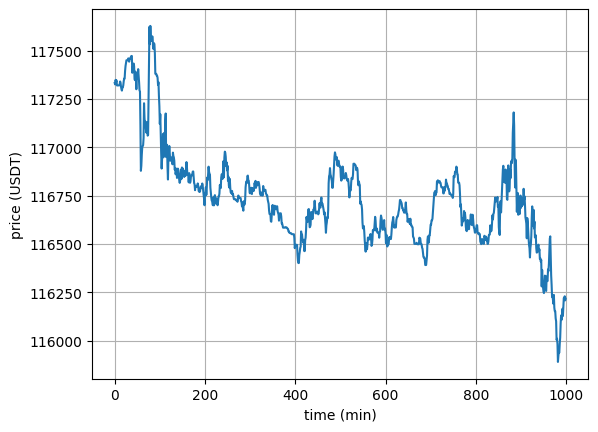

In [4]:
import numpy as np
file_path = "data/btc_1min_last_1000.csv"
data = pd.read_csv(file_path, usecols=["open"])
x = np.arange(len(data))

plt.plot(x,data["open"], '-')
plt.xlabel("time (min)")
plt.ylabel("price (USDT)")
plt.grid()
plt.show()

The issue here is that we are not in the same configuration as with earthquakes. Each one-minute interval aggregates many transactions, so we cannot assume that these transactions form a "point process." To address this, there are two possible solutions:
- Aggregate over a smaller time scale (e.g., milliseconds or microseconds)
- Switch to a less liquid cryptocurrency, where the number of buyers and sellers per minute is low enough to approximate a point process in time.

In both cases, theory suggests that these point processes are self-exciting. This means that past events influence future occurrences. In the framework of Hawkes processes, each event has a positive impact on the intensity of the underlying Poisson process.

## Part 2: Poisson Processes

Let's intoduce the Hawkes processes. They are a close to Poisson's Processes that we will present first. 

### Homogeneous Poisson's Processes


**Definition: Homogeneous Poisson Process**

A stochastic process $(N_t)_{t \in \mathbb{R}_+}$ is called a **homogeneous Poisson process** with intensity $\lambda > 0$ if:
1. $N_0 = 0$ (almost surely);
2. The process has **independent increments**: for any $0 \leq t_1 < t_2 < \dots < t_n$, the random variables $N_{t_1}, N_{t_2} - N_{t_1}, \dots, N_{t_n} - N_{t_{n-1}}$ are independent;
3. The process has **stationary increments**: for any $s, t \geq 0$, $N_{t+s} - N_t \sim \text{Poisson}(\lambda s)$;
4. The paths of $(N_t)$ are **càdlàg** (right-continuous with left limits).


Poisson processes are part of the family of processes named **counting processes** because they take values in $\mathbb{N}$ and are non-decreasing in time. More intuitively, a homogeneous Poisson process can be represented as a sum of independent and identically distributed (i.i.d.) exponential random variables with parameter $\lambda$. Specifically, if $(T_i)_{i \geq 1}$ are i.i.d. random variables with $T_i \sim \text{Exp}(\lambda)$, then the Poisson process $(N_t)_{t \geq 0}$ can be written as:

$$
N_t = \sum_{i=1}^{\infty} \mathbf{1}_{\{T_1 + T_2 + \dots + T_i \leq t\}}.
$$

This representation highlights that $N_t$ counts the number of "events" (or "arrivals") up to time $t$, where the inter-arrival times $(T_i)$ are exponentially distributed with parameter $\lambda$.


To simulate a homogeneous Poisson process with intensity $\lambda$ over the interval $[0, t]$:
1. **Simulate the number of events**: Generate a Poisson random variable $N \sim \text{Poisson}(\lambda t)$, representing the total number of events in $[0, t]$.
2. **Distribute events uniformly**: Generate $N$ independent and uniformly distributed random variables on $[0, t]$, representing the event times.

This method leverages the property that, conditional on $N = n$, the event times are independent and uniformly distributed over $[0, t]$.



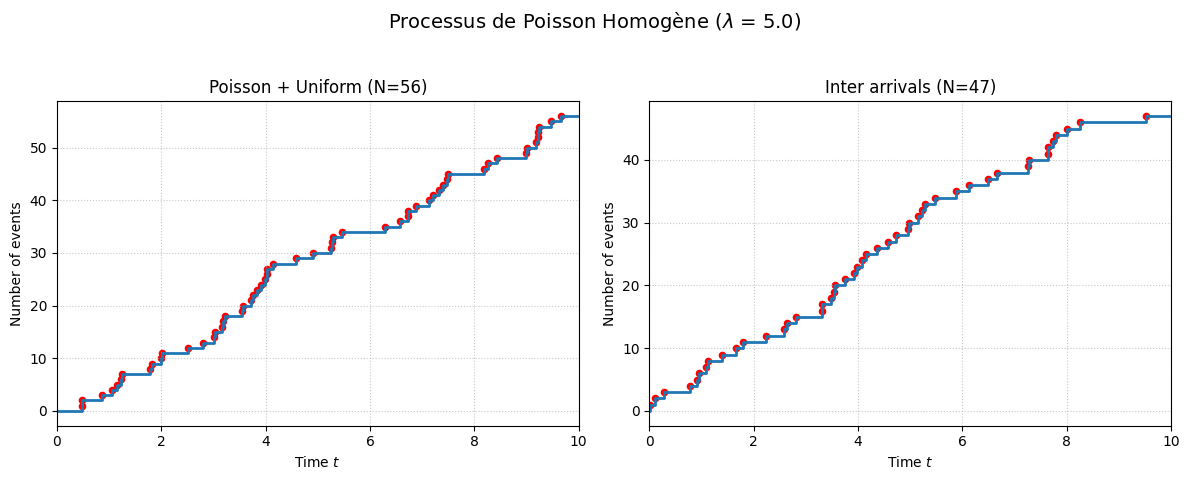

In [5]:
import numpy as np

def pp_inter_arrival(rate: float, T: float) -> np.ndarray:
    """Exponential modelisation of arrival times"""
    jumps = np.cumsum(np.random.exponential(scale=1/rate, size=int(2 * rate * T + 10)))
    return jumps[jumps < T]

def pp_uniform(rate: float, T: float) -> np.ndarray:
    """Poisson's law model and order of uniform random variables (vectorial)"""
    N = np.random.poisson(rate * T)
    return np.sort(np.random.uniform(0, T, N))

LAMBDA = 5.0  
T_MAX = 10.0  


processes = {
    "Poisson + Uniform": pp_uniform(LAMBDA, T_MAX),
    "Inter arrivals": pp_inter_arrival(LAMBDA, T_MAX)
}

plt.figure(figsize=(12, 5))
plt.suptitle(f"Processus de Poisson Homogène ($\\lambda$ = {LAMBDA})", fontsize=14)

for i, (name, arrivals) in enumerate(processes.items()):
    ax = plt.subplot(1, 2, i + 1)
    
    t = np.insert(arrivals, 0, 0)
    n = np.arange(len(t))
    t_plot = np.append(t, T_MAX)
    n_plot = np.append(n, n[-1])

    ax.step(t_plot, n_plot, where='post', linewidth=2)
    ax.scatter(arrivals, n[1:], color='red', marker='o', s=20)

    ax.set_title(f"{name} (N={len(arrivals)})")
    ax.set_xlabel("Time $t$")
    ax.set_ylabel("Number of events")
    ax.set_xlim(0, T_MAX)
    ax.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

### Non-Homogeneous Poisson Processes

**Definition: Non-Homogeneous Poisson Process**

A stochastic process $(N_t)_{t \in \mathbb{R}_+}$ is called a **non-homogeneous Poisson process** with intensity function $\Lambda: \mathbb{R}_+ \to \mathbb{R}_+$ if:
1. $N_0 = 0$ (almost surely);
2. The process has **independent increments**: for any $0 \leq t_1 < t_2 < \dots < t_n$, the random variables $N_{t_1}, N_{t_2} - N_{t_1}, \dots, N_{t_n} - N_{t_{n-1}}$ are independent;
3. For any $s, t \geq 0$, the increment $N_{t+s} - N_t$ follows a Poisson distribution with mean $\Lambda(t+s) - \Lambda(t)$, i.e.,
   $N_{t+s} - N_t \sim \text{Poisson}\left(\int_t^{t+s} \lambda(u) \, du\right)$,
   where $\lambda(u)$ is the **intensity function** and $\Lambda(t) = \int_0^t \lambda(u) \, du$ is the **cumulative intensity function**;
4. The paths of $(N_t)$ are **càdlàg** (right-continuous with left limits).






To simulate a non-homogeneous Poisson process with intensity function $\lambda(t)$ over $[0, T]$:
1. Compute the **cumulative intensity function** $\Lambda(t) = \int_0^t \lambda(u) \, du$.
2. Simulate a **homogeneous Poisson process** $(N_s^*)_{s \geq 0}$ with unit rate (intensity $1$) up to time $\Lambda(T)$.
3. Let $0 < S_1 < S_2 < \dots < S_{N^*_{\Lambda(T)}}$ be the event times of the homogeneous process. The event times of the non-homogeneous process are given by $T_i = \Lambda^{-1}(S_i)$, where $\Lambda^{-1}$ is the inverse of $\Lambda$.

This method exploits the fact that a non-homogeneous Poisson process can be obtained by time-rescaling a homogeneous Poisson process.


<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\L'
<>:14: SyntaxWarning: invalid escape sequence '\l'
<>:23: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Benjamin Mottier\AppData\Local\Temp\ipykernel_7404\1366216591.py:14: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f"Non homogeneous Poisson process with intensity $\lambda(t) = t$", fontsize=14)
C:\Users\Benjamin Mottier\AppData\Local\Temp\ipykernel_7404\1366216591.py:23: SyntaxWarning: invalid escape sequence '\L'
  plt.plot(t_theory, lambda_cum, color='gray', linestyle='--', alpha=0.7, label="Expectancy $\Lambda(t) = t^2/2$")


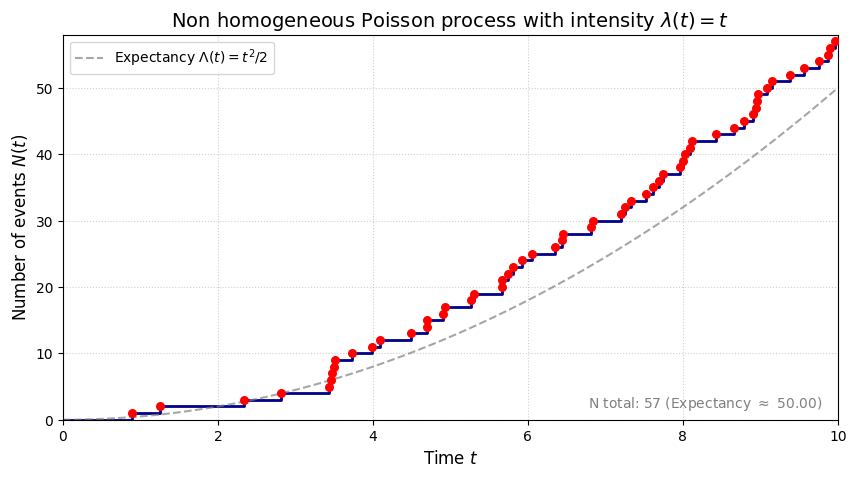

In [8]:
import numpy as np
import matplotlib.pyplot as plt


T_MAX = 10.0  
L_FINAL = (T_MAX**2) / 2 

N_total = np.random.poisson(L_FINAL)
S_star = np.sort(np.random.uniform(0, L_FINAL, N_total))
ppnh_arrivals = np.sqrt(2 * S_star)


plt.figure(figsize=(10, 5))
plt.title(f"Non homogeneous Poisson process with intensity $\lambda(t) = t$", fontsize=14)
t_points = np.insert(ppnh_arrivals, 0, 0)
n_values = np.arange(len(t_points))
t_plot = np.append(t_points, T_MAX)
n_plot = np.append(n_values, n_values[-1])
plt.step(t_plot, n_plot, where='post', color='darkblue', linewidth=2)
plt.scatter(ppnh_arrivals, n_values[1:], color='red', marker='o', s=30, zorder=5)
t_theory = np.linspace(0, T_MAX, 100)
lambda_cum = (t_theory**2) / 2
plt.plot(t_theory, lambda_cum, color='gray', linestyle='--', alpha=0.7, label="Expectancy $\Lambda(t) = t^2/2$")
plt.xlabel("Time $t$", fontsize=12)
plt.ylabel("Number of events $N(t)$", fontsize=12)
plt.xlim(0, T_MAX)
plt.ylim(0, max(N_total + 1, np.max(lambda_cum) + 1))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()

plt.text(0.98, 0.02, f'N total: {N_total} (Expectancy $\\approx$ {L_FINAL:.2f})', 
         transform=plt.gca().transAxes, 
         fontsize=10, color='gray', ha='right', va='bottom')

plt.show()

## Part 3: Hawkes Processes
**Definition: Hawkes Process** [1]
A **Hawkes process** is a counting process $(N_t)_{t \geq 0}$ whose **conditional intensity process** for $t \geq 0$ is given by:
$$
\lambda_t^* = \lambda + \sum_{T_i < t} \mu(t - T_i),
$$
where:
- $\lambda > 0$ is the **background arrival rate**,
- $\mu: \mathbb{R}_+ \to \mathbb{R}_+$ is the **excitation function**,
- $(T_i)$ are the past event times of the process.

The Hawkes process models **self-exciting** behavior, where the occurrence of an event increases the likelihood of future events through the excitation function $\mu$. Unlike homogeneous Poisson processes, the conditional intensity process depends on the random jump times.

Let's consider some classical examples of Hawkes processes for different excitation functions:


**Example 1:**
We consider the following excitation function:
$$
\mu(t) \longmapsto \alpha e^{-\beta t}
$$
where $\alpha$ and $\beta$ are two positive parameters to be determined in a given situation. Here, $\alpha$ represents the intensity brought by the occurrence of a jump, and $\beta$ is the speed at which the effect of a jump disappears over time.

To simulate this, we use **Ogata's algorithm** (the principle of this algorithm is similar to the accept-reject step in the Metropolis-Hastings algorithm). Before proceeding with Ogata's algorithm, we need to establish the following quantities:
- $M(t)$: an upper bound of the intensity $\lambda(t)$ (for a given $\lambda(t)$, $M$ is constant).
- $T$: a jump time (valued in $\mathbb{R}$).
- $\mathcal{U}$: the uniform distribution over $[0,1]$, and $U$: an instance of this distribution generated independently of the others.

Let's describe the algorithm:


```
L <- [] # list of events
t <- 0
while t < T_max:  # Assuming T_max is the simulation horizon
    # Generate candidate
    M <- λ(t)
    T <- Exp(M)  # Exponential random variable with rate M
    # Acceptance test
    U <- Uni[0,1]  # Uniform random variable
    if U <= λ(t + T)/M:
        L <- L ∪ {t + T}  # Add the event to the list
        λ(.) <- λ(.) + μ_{t+T}(.)  # Update the intensity function
    t <- t + T
return L
```

The following code contains two functions:
1. The first implements Ogata's algorithm under the conditions mentioned above.
2. The second simulates the evolution of the intensity over time. 


<>:81: SyntaxWarning: invalid escape sequence '\l'
<>:82: SyntaxWarning: invalid escape sequence '\l'
<>:86: SyntaxWarning: invalid escape sequence '\l'
<>:81: SyntaxWarning: invalid escape sequence '\l'
<>:82: SyntaxWarning: invalid escape sequence '\l'
<>:86: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Benjamin Mottier\AppData\Local\Temp\ipykernel_7404\1757351003.py:81: SyntaxWarning: invalid escape sequence '\l'
  ax2.plot(t_plot, lambda_t, label="Conditional Intensity $\lambda(t)$", color='blue')
C:\Users\Benjamin Mottier\AppData\Local\Temp\ipykernel_7404\1757351003.py:82: SyntaxWarning: invalid escape sequence '\l'
  ax2.hlines(mu, 0, T, color='green', linestyle=':', label="Baseline $\lambda_0$")
C:\Users\Benjamin Mottier\AppData\Local\Temp\ipykernel_7404\1757351003.py:86: SyntaxWarning: invalid escape sequence '\l'
  ax2.set_ylabel("$\lambda(t)$")


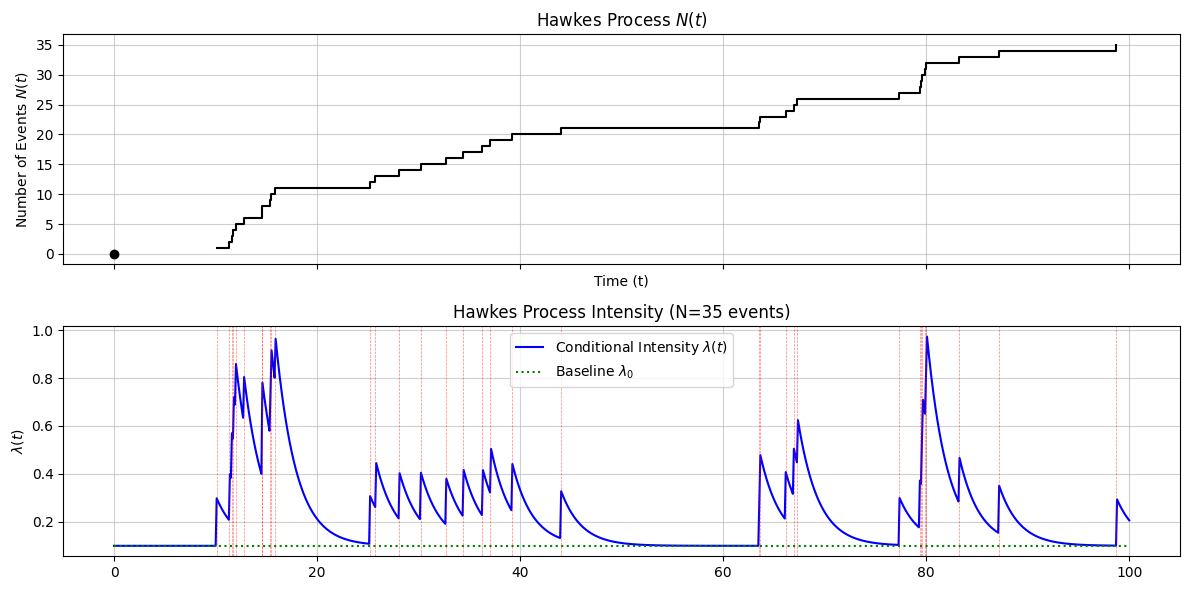

In [9]:
import numpy as np
import matplotlib.pyplot as plt


T = 100.0  
mu = 0.1    
alpha = 0.2 
beta = 0.5 

def simulate_hawkes_exp(mu, alpha, beta, T):
    """Simulation of a Hawkes process using the thinning algorithm."""
    times = [0.0]
    t = 0.0
    
    while t < T:
        past_diffs = t - np.array(times) 
        current_intensity = mu + np.sum(alpha * np.exp(-beta * past_diffs))
        lambda_star = current_intensity
        
        u1 = np.random.rand()
        dt = -np.log(u1) / lambda_star 
        t_prime = t + dt
        
        if t_prime >= T:
            break
            

        future_diffs = t_prime - np.array(times)
        lambda_t_prime = mu + np.sum(alpha * np.exp(-beta * future_diffs))
        
        u2 = np.random.rand()
        if u2 <= lambda_t_prime / lambda_star:
            times.append(t_prime)
            

        t = t_prime
        
    return np.array(times[1:]) 


event_times = simulate_hawkes_exp(mu, alpha, beta, T)
N = len(event_times)


def get_intensity(t_vals, mu, alpha, beta, event_times):
    """Vectorized calculation of lambda(t) for plotting."""
    # Intensity is baseline + sum of excitation kernels
    intensity = np.full_like(t_vals, mu, dtype=float)
    
    # Calculate the excitation for each t in t_vals from all past events
    for t_event in event_times:
        # Only events *before* t contribute
        relevant_t = t_vals[t_vals > t_event]
        if len(relevant_t) > 0:
            time_diffs = relevant_t - t_event
            excitation = alpha * np.exp(-beta * time_diffs)
            
            # Map the excitation back to the corresponding intensity array indices
            indices = np.where(t_vals > t_event)
            intensity[indices] += excitation
            
    return intensity

# Time points for plotting
t_plot = np.linspace(0.0, T, 1000)
lambda_t = get_intensity(t_plot, mu, alpha, beta, event_times)
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot 1: Cumulative Counting Process N(t)
ax1 = axes[0]
N_t = np.arange(1, N + 1)
ax1.step(event_times, N_t, where='post', color='black')
ax1.plot([0.0], [0.0], 'ko')
ax1.set_title("Hawkes Process $N(t)$")
ax1.set_xlabel("Time (t)")
ax1.set_ylabel("Number of Events $N(t)$")
ax1.grid(True, alpha=0.6)

# Plot 2: Conditional Intensity
ax2 = axes[1]
ax2.plot(t_plot, lambda_t, label="Conditional Intensity $\lambda(t)$", color='blue')
ax2.hlines(mu, 0, T, color='green', linestyle=':', label="Baseline $\lambda_0$")
for t_i in event_times:
    ax2.axvline(x=t_i, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
ax2.set_title(f"Hawkes Process Intensity (N={N} events)")
ax2.set_ylabel("$\lambda(t)$")
ax2.legend()
ax2.grid(True, alpha=0.6)

plt.tight_layout()
plt.show()

*Remark: The intensity of a Hawkes process can explode to infinity if a certain criterion is not satisfied. Specifically, the average number of "followers" (or offspring) triggered by an event must be strictly less than 1. Under the previous conditions, this is equivalent to requiring that $\alpha < \beta$.*


## Part 4: Application to Quantitative Finance
Some traders develop algorithms designed to quickly analyze the short-term trend of a stock (positive or negative). One possible approach is based on the following observation: **sell orders tend to trigger more sell orders, while buy orders tend to trigger more buy orders**. This self-exciting behavior of buyers and sellers makes the Hawkes process a suitable model for such dynamics.

In this context, we can choose the excitation function as before, but we now consider **two independent Hawkes processes**: one for sell events and one for buy events.

The princip of the code is learning the paramters to calibrate the hawkes process with a rolling window above the data, deducing the behavior of the stock and catching, when it occurs, the moments of big purchases and big sales. We skip here the justification of the estimators used

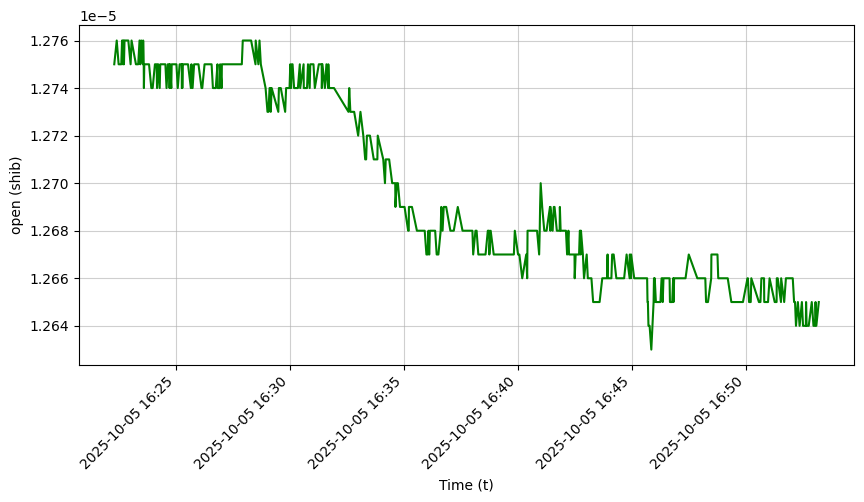

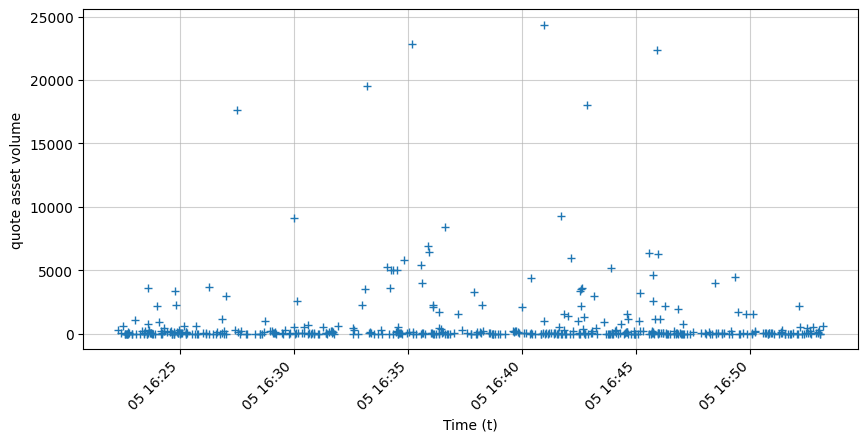

In [10]:
file_path = "data/shibusdt_500ms.csv"
data_shib = pd.read_csv(file_path, usecols=["open_time", "open","close", "quote_asset_volume","taker_buy_quote"])


data_shib["time"] = pd.to_datetime(data_shib["open_time"], utc=True) 


fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(data_shib["time"], data_shib["open"], '-', color='g')
ax1.set_xlabel("Time (t)")
ax1.set_ylabel("open (shib)")
ax1.grid(True, alpha=0.6)
fig.autofmt_xdate(rotation=45) 
fig, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(data_shib["time"], data_shib["quote_asset_volume"], '+')
ax2.set_xlabel("Time (t)")
ax2.set_ylabel("quote asset volume")
ax2.grid(True, alpha=0.6)

fig.autofmt_xdate(rotation=45) 

date_form = mdates.DateFormatter('%Y-%m-%d %H:%M') 
ax1.xaxis.set_major_formatter(date_form)

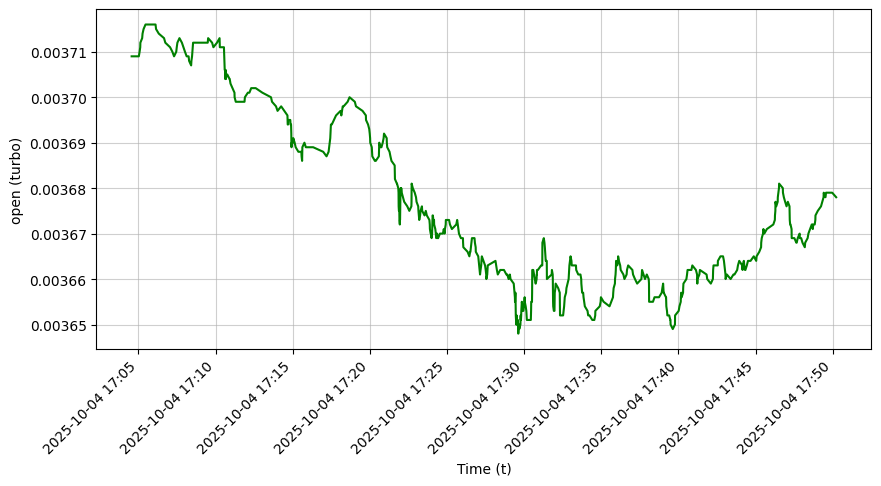

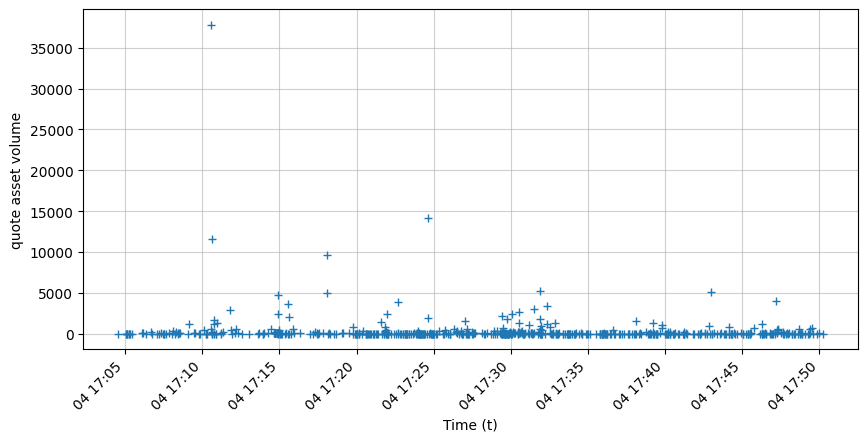

In [11]:
file_path = "data/turbousdt_500ms.csv"
data_turbo = pd.read_csv(file_path, usecols=["open_time", "open","close", "quote_asset_volume","taker_buy_quote"])


data_turbo["time"] = pd.to_datetime(data_turbo["open_time"], utc=True) 


fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(data_turbo["time"], data_turbo["open"], '-', color='g')
ax1.set_xlabel("Time (t)")
ax1.set_ylabel("open (turbo)")
ax1.grid(True, alpha=0.6)
fig.autofmt_xdate(rotation=45) 
fig, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(data_turbo["time"], data_turbo["quote_asset_volume"], '+')
ax2.set_xlabel("Time (t)")
ax2.set_ylabel("quote asset volume")
ax2.grid(True, alpha=0.6)

fig.autofmt_xdate(rotation=45) 

date_form = mdates.DateFormatter('%Y-%m-%d %H:%M') 
ax1.xaxis.set_major_formatter(date_form)

We observe here, for Shiba Inu and Turbo Coin, a map of all trades grouped by 0.5-second intervals, as well as a map of the quote asset volumes. We assume that each trade is executed by a single actor. To build our model (using a Hawkes process), we focus only on significant events—those with high quote asset volumes—as indicators.
However, this approach presents a major challenge in estimation: the separation of data into training and test sets. Unfortunately, the dataset is not extensive enough to allow for this division, so we must use the same data for both training and testing.

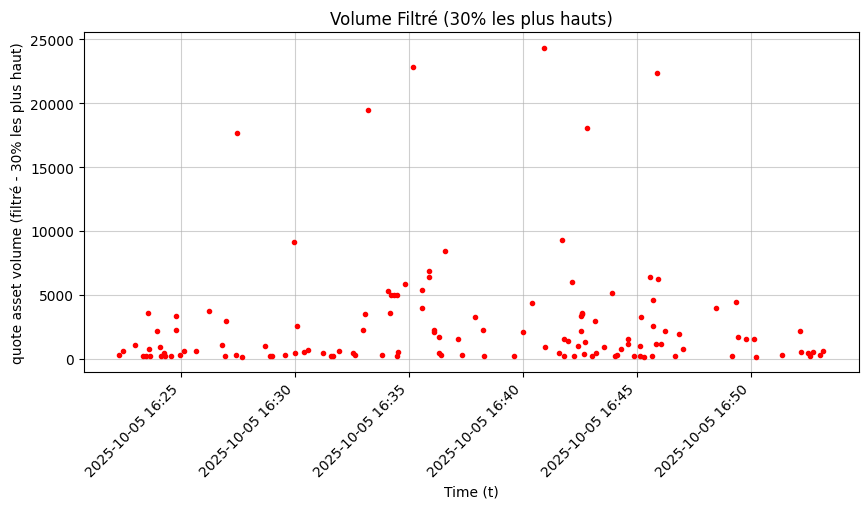

In [12]:

# 1. Calculate the 10th quantile of the volume
quantile_90 = data_shib['quote_asset_volume'].quantile(0.7)
data_filtered_high_volume_shib = data_shib[data_shib['quote_asset_volume'] > quantile_90].copy()



fig, ax3 = plt.subplots(figsize=(10, 5))
ax3.plot(data_filtered_high_volume_shib["time"], data_filtered_high_volume_shib["quote_asset_volume"], '.', color='red')
ax3.set_xlabel("Time (t)")
ax3.set_ylabel("quote asset volume (filtré - 30% les plus haut)")
ax3.grid(True, alpha=0.6)
fig.autofmt_xdate(rotation=45) 
ax3.xaxis.set_major_formatter(date_form) 
plt.title("Volume Filtré (30% les plus hauts)")
plt.show()

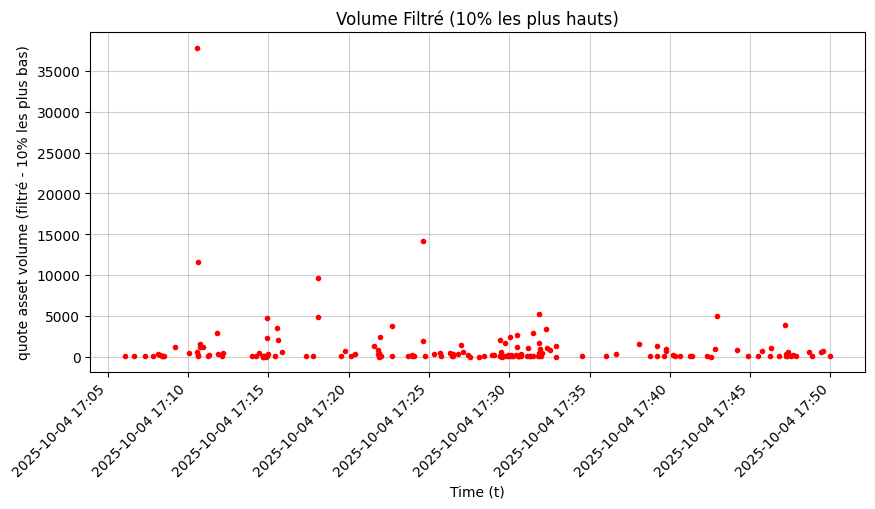

In [13]:

# 1. Calculate the 10th quantile of the volume
quantile_90 = data_turbo['quote_asset_volume'].quantile(0.7)
data_filtered_high_volume_turbo = data_turbo[data_turbo['quote_asset_volume'] > quantile_90].copy()


fig, ax3 = plt.subplots(figsize=(10, 5))
ax3.plot(data_filtered_high_volume_turbo["time"], data_filtered_high_volume_turbo["quote_asset_volume"], '.', color='red')
ax3.set_xlabel("Time (t)")
ax3.set_ylabel("quote asset volume (filtré - 10% les plus bas)")
ax3.grid(True, alpha=0.6)
fig.autofmt_xdate(rotation=45) 
ax3.xaxis.set_major_formatter(date_form) 
plt.title("Volume Filtré (10% les plus hauts)")
plt.show()

In [15]:

#Turbo
data_turbo_modified = data_filtered_high_volume_turbo.sort_values(by='time').reset_index(drop=True)
rise_events_df_turbo = data_turbo_modified[(data_turbo_modified["taker_buy_quote"]/data_turbo_modified['quote_asset_volume']) > 0.5].copy()
fall_events_df_turbo = data_turbo_modified[(data_turbo_modified["taker_buy_quote"]/data_turbo_modified['quote_asset_volume']) < 0.5].copy()
start_time_turbo = data_turbo['time'].min()
rise_times_turbo = (rise_events_df_turbo['time'] - start_time_turbo).dt.total_seconds().values
fall_times_turbo = (fall_events_df_turbo['time'] - start_time_turbo).dt.total_seconds().values
print(type(fall_times_turbo))
T_TURBO = (max(data_turbo['time']) - start_time_turbo).total_seconds()

#shib
data_shib_modified = data_filtered_high_volume_shib.sort_values(by='time').reset_index(drop=True)
rise_events_df_shib = data_shib_modified[(data_shib_modified["taker_buy_quote"]/data_shib_modified['quote_asset_volume']) > 1/2].copy()
fall_events_df_shib = data_shib_modified[(data_shib_modified["taker_buy_quote"]/data_shib_modified['quote_asset_volume']) < 1/2].copy()
start_time_shib = data_shib['time'].min()
rise_times_shib = (rise_events_df_shib['time'] - start_time_shib).dt.total_seconds().values
fall_times_shib = (fall_events_df_shib['time'] - start_time_shib).dt.total_seconds().values
T_SHIB = (max(data_shib['time']) - start_time_shib).total_seconds()





<class 'numpy.ndarray'>


(0.02864900310437507, 0.08471374337086339, 1.4957177898373977)
(0.023894820382441683, 0.39442609970808723, 34.68388484399614)


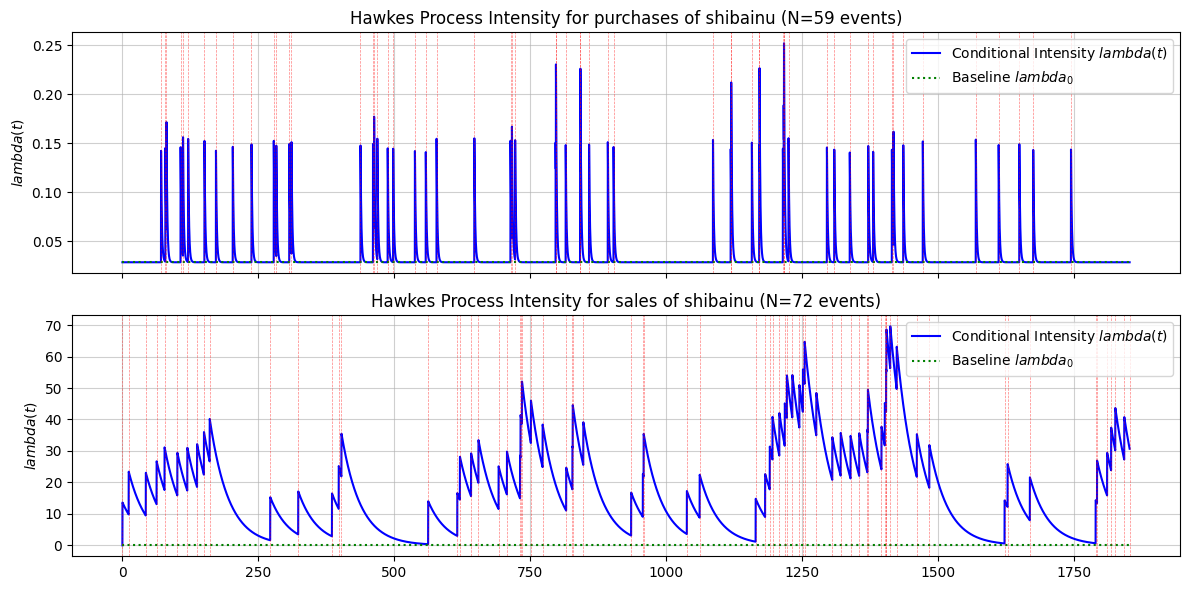

In [16]:
# --- 4. Plotting ---
# Time points for plotting
t_plot_shib = np.linspace(0.0, T_SHIB, 10000)
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)


# plot 1: Conditional Intensity for purchase
rise_hawkes_model1 = hi.ExpHawkesProcessInference()
params = rise_hawkes_model1.estimate_grid(timestamps = rise_times_shib[1:],T = T_SHIB, return_params = True)
mu, alpha, beta = params[0], params[1]* params[2], 1/params[2] 
print(params)
lambda_t_pos_shib = get_intensity(t_plot_shib, mu, alpha, beta, rise_times_shib)
ax1 = axes[0]
ax1.plot(t_plot_shib, lambda_t_pos_shib, label="Conditional Intensity $lambda(t)$", color='blue')
ax1.hlines(mu, 0, T_SHIB, color='green', linestyle=':', label="Baseline $lambda_0$")
for t_i in rise_times_shib:
    ax1.axvline(x=t_i, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.set_title(f"Hawkes Process Intensity for purchases of shibainu (N={len(rise_times_shib)} events)")
ax1.set_ylabel("$lambda(t)$")
ax1.legend()
ax1.grid(True, alpha=0.6)

# Plot 2: Conditional Intensity for purchase
rise_hawkes_model2 = hi.ExpHawkesProcessInference()
params = rise_hawkes_model2.estimate_grid(
    timestamps=fall_times_shib[1:],
    T=T_SHIB,
    return_params=True
)
print(params)
mu, alpha, beta = params[0], params[1]* params[2], 1/params[2]
lambda_t_neg_shib = get_intensity(t_plot_shib, mu, alpha, beta, fall_times_shib)
ax2 = axes[1]
ax2.plot(t_plot_shib, lambda_t_neg_shib, label="Conditional Intensity $lambda(t)$", color='blue')
ax2.hlines(mu, 0, T_SHIB, color='green', linestyle=':', label="Baseline $lambda_0$")
for t_i in fall_times_shib:
    ax2.axvline(x=t_i, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
ax2.set_title(f"Hawkes Process Intensity for sales of shibainu (N={len(fall_times_shib)} events)")
ax2.set_ylabel("$lambda(t)$")
ax2.legend()
ax2.grid(True, alpha=0.6)

plt.tight_layout()
plt.show()

(0.0195335584627038, 0.23551327702590047, 3.729922215231812)
(0.016329785232993263, 0.539366048218974, 18.69591624110352)


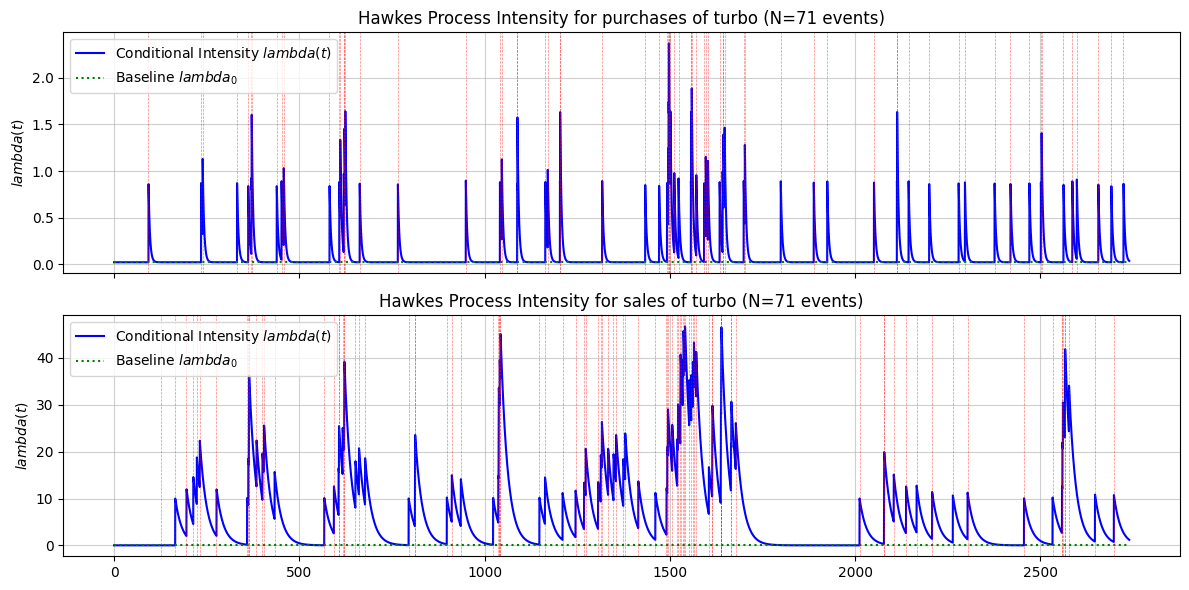

In [17]:
# --- 4. Plotting ---
t_plot_turbo = np.linspace(0.0, T_TURBO, 10000)
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# plot 1: Conditional Intensity for purchase
rise_hawkes_model1 = hi.ExpHawkesProcessInference()
params = rise_hawkes_model1.estimate_grid(timestamps = rise_times_turbo[1:],T = T_TURBO, return_params = True)
print(params)
mu, alpha, beta = params[0], params[1]* params[2], 1/params[2]
lambda_t_pos_turbo = get_intensity(t_plot_turbo, mu, alpha, beta, rise_times_turbo)
ax1 = axes[0]
ax1.plot(t_plot_turbo, lambda_t_pos_turbo, label="Conditional Intensity $lambda(t)$", color='blue')
ax1.hlines(mu, 0, T_TURBO, color='green', linestyle=':', label="Baseline $lambda_0$")
for t_i in rise_times_turbo:
    ax1.axvline(x=t_i, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.set_title(f"Hawkes Process Intensity for purchases of turbo (N={len(rise_times_turbo)} events)")
ax1.set_ylabel("$lambda(t)$")
ax1.legend()
ax1.grid(True, alpha=0.6)

# Plot 2: Conditional Intensity for purchase
rise_hawkes_model2 = hi.ExpHawkesProcessInference()
params = rise_hawkes_model2.estimate_grid(
    timestamps=fall_times_turbo[1:],
    T=T_TURBO,
    return_params=True
)
mu, alpha, beta =  params[0], params[1]* params[2], 1/params[2]
print(params)
lambda_t_neg_turbo = get_intensity(t_plot_turbo, mu, alpha, beta, fall_times_turbo[1:])
ax2 = axes[1]
ax2.plot(t_plot_turbo, lambda_t_neg_turbo, label="Conditional Intensity $lambda(t)$", color='blue')
ax2.hlines(mu, 0, T_TURBO, color='green', linestyle=':', label="Baseline $lambda_0$")
for t_i in fall_times_turbo:
    ax2.axvline(x=t_i, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
ax2.set_title(f"Hawkes Process Intensity for sales of turbo (N={len(rise_times_turbo)} events)")
ax2.set_ylabel("$lambda(t)$")
ax2.legend()
ax2.grid(True, alpha=0.6)

plt.tight_layout()
plt.show()

We now build a function that has two roles. The first one ist to make a mean on an open window to decide if the signal is more a purchase signal or a sale signal. To make it clea we build the difference of those mean normalised.

In [18]:
def normalize_and_smooth_intensity(intensity_values, alpha_decay=0.9, window_size=10):
    """
    Normalize intensities by their integral and apply exponential weighted smoothing.
    
    Parameters:
    - intensity_values: array of intensity values
    - alpha_decay: decay factor for exponential weighting (between 0 and 1)
    - window_size: maximum number of previous values to consider
    
    Returns:
    - smoothed_normalized_intensity: processed intensity values
    """
    # Normalize by integral (approximate with sum * dt)
    integral_approx = np.sum(intensity_values)
    if integral_approx == 0:
        normalized_intensity = intensity_values
    else:
        normalized_intensity = intensity_values / integral_approx
    
    # Apply exponential weighted moving average
    smoothed_intensity = np.zeros_like(normalized_intensity)
    
    for i in range(len(normalized_intensity)):
        if i == 0:
            smoothed_intensity[i] = normalized_intensity[i]
        else:
            # Calculate weighted sum of previous values
            start_idx = max(0, i - window_size + 1)
            weights_sum = 0
            weighted_value = 0
            
            for j in range(start_idx, i + 1):
                # Exponential decay weight: alpha^(distance from current point)
                weight = alpha_decay ** (i - j)
                weighted_value += weight * normalized_intensity[j]
                weights_sum += weight
            
            # Normalize by sum of weights
            smoothed_intensity[i] = weighted_value / weights_sum if weights_sum > 0 else normalized_intensity[i]
    
    return smoothed_intensity

def compute_signal_difference(positive_intensity, negative_intensity, alpha_decay=0.9, window_size=10):
    """
    Compute the difference between smoothed normalized positive and negative intensities.
    
    Parameters:
    - positive_intensity: intensity values for purchases
    - negative_intensity: intensity values for sales
    - alpha_decay: decay factor for exponential weighting
    - window_size: maximum number of previous values to consider
    
    Returns:
    - signal_difference: positive_smooth - negative_smooth
    """
    # Process both intensities
    positive_smooth = normalize_and_smooth_intensity(positive_intensity, alpha_decay, window_size)
    negative_smooth = normalize_and_smooth_intensity(negative_intensity, alpha_decay, window_size)
    
    # Compute difference
    signal_difference = positive_smooth - negative_smooth
    
    return signal_difference, positive_smooth, negative_smooth

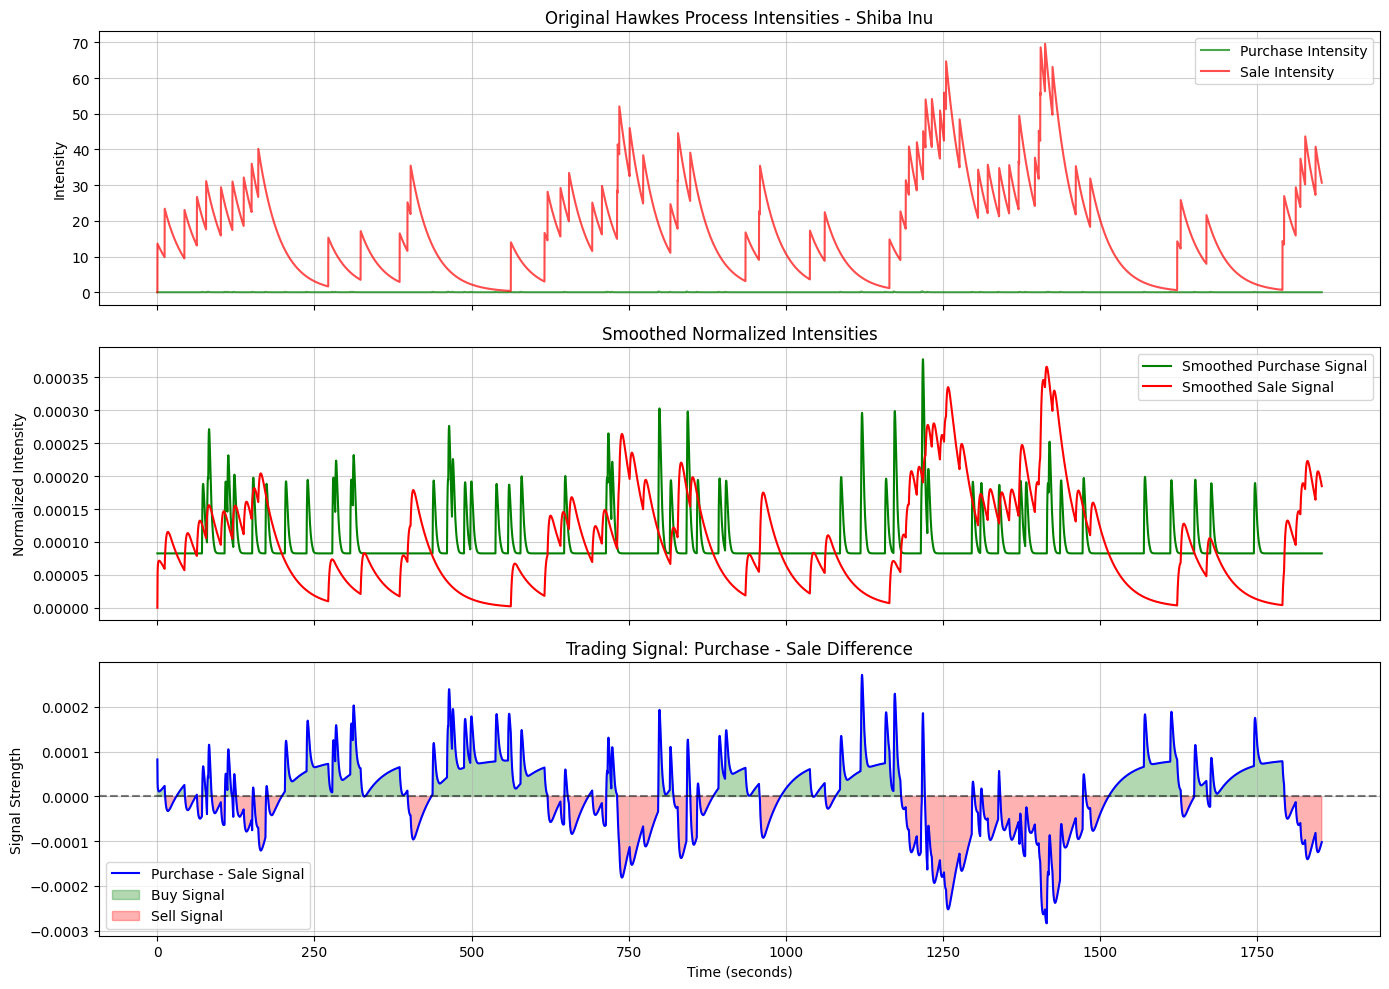

Signal statistics for Shiba Inu:
Mean signal: 0.000000
Signal std: 0.000083
Max signal: 0.000271
Min signal: -0.000283


In [19]:
# Apply the functions to Shiba Inu data
alpha_decay = 0.92  # Decay factor for exponential weighting (increased for smoother averaging)
window_size = 50    # Local window size (increased for bigger smoothing window)

# Compute signal difference for Shiba Inu
signal_diff_shib, pos_smooth_shib, neg_smooth_shib = compute_signal_difference(
    lambda_t_pos_shib, lambda_t_neg_shib, alpha_decay, window_size
)

# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: Original intensities
ax1 = axes[0]
ax1.plot(t_plot_shib, lambda_t_pos_shib, label="Purchase Intensity", color='green', alpha=0.7)
ax1.plot(t_plot_shib, lambda_t_neg_shib, label="Sale Intensity", color='red', alpha=0.7)
ax1.set_title("Original Hawkes Process Intensities - Shiba Inu")
ax1.set_ylabel("Intensity")
ax1.legend()
ax1.grid(True, alpha=0.6)

# Plot 2: Smoothed normalized intensities
ax2 = axes[1]
ax2.plot(t_plot_shib, pos_smooth_shib, label="Smoothed Purchase Signal", color='green')
ax2.plot(t_plot_shib, neg_smooth_shib, label="Smoothed Sale Signal", color='red')
ax2.set_title("Smoothed Normalized Intensities")
ax2.set_ylabel("Normalized Intensity")
ax2.legend()
ax2.grid(True, alpha=0.6)

# Plot 3: Signal difference
ax3 = axes[2]
ax3.plot(t_plot_shib, signal_diff_shib, label="Purchase - Sale Signal", color='blue')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.fill_between(t_plot_shib, signal_diff_shib, 0, 
                 where=(signal_diff_shib > 0), color='green', alpha=0.3, label='Buy Signal')
ax3.fill_between(t_plot_shib, signal_diff_shib, 0, 
                 where=(signal_diff_shib < 0), color='red', alpha=0.3, label='Sell Signal')
ax3.set_title("Trading Signal: Purchase - Sale Difference")
ax3.set_xlabel("Time (seconds)")
ax3.set_ylabel("Signal Strength")
ax3.legend()
ax3.grid(True, alpha=0.6)

plt.tight_layout()
plt.show()

print(f"Signal statistics for Shiba Inu:")
print(f"Mean signal: {np.mean(signal_diff_shib):.6f}")
print(f"Signal std: {np.std(signal_diff_shib):.6f}")
print(f"Max signal: {np.max(signal_diff_shib):.6f}")
print(f"Min signal: {np.min(signal_diff_shib):.6f}")

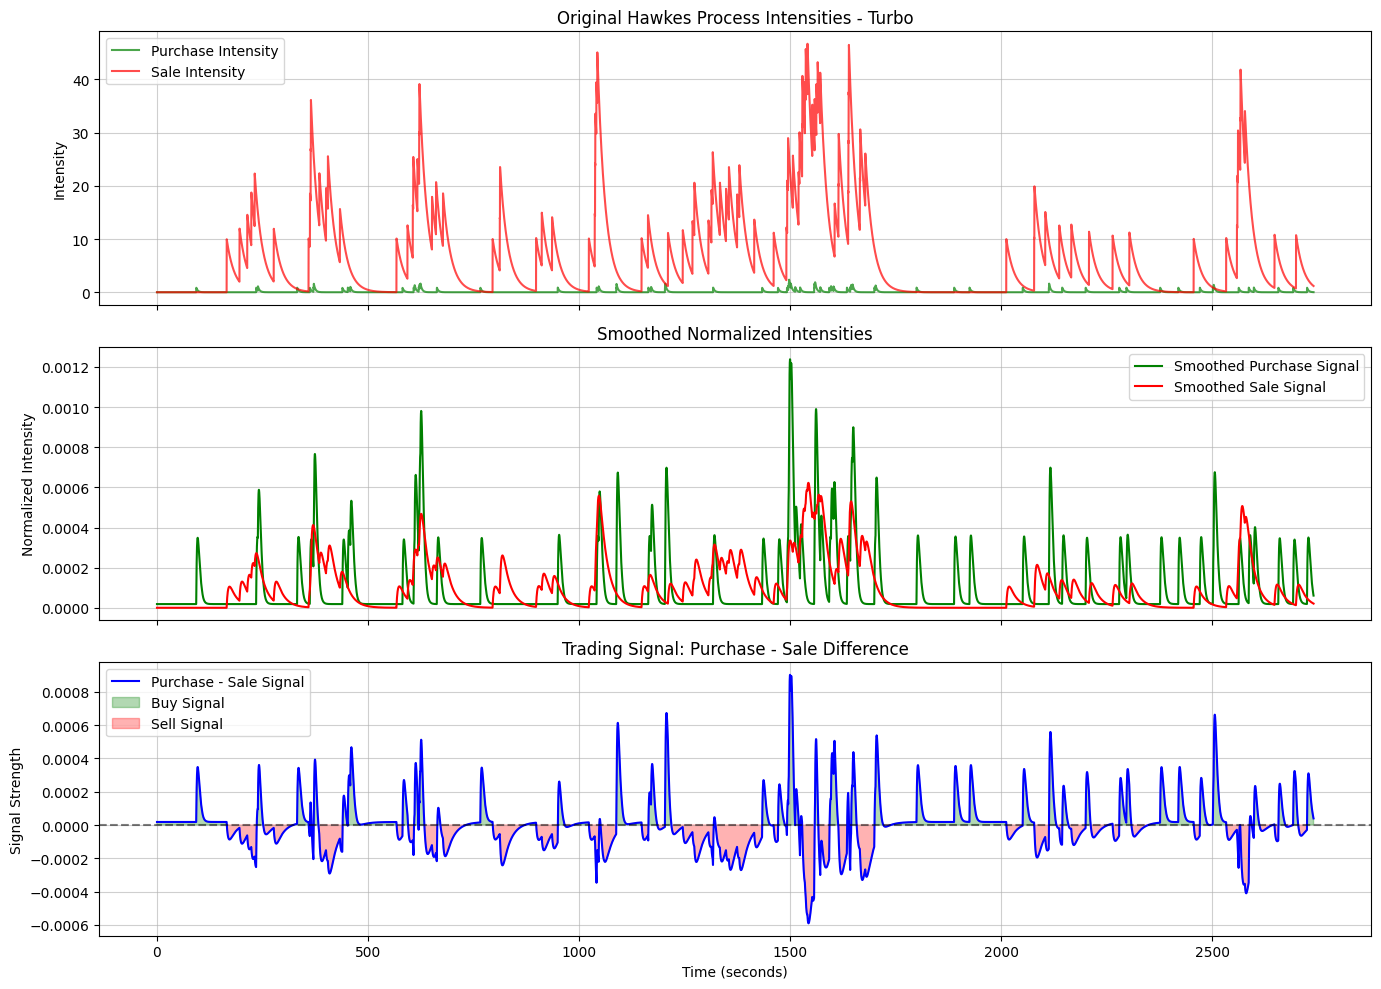

Signal statistics for Turbo:
Mean signal: -0.000000
Signal std: 0.000160
Max signal: 0.000902
Min signal: -0.000590


In [20]:
# Apply the same analysis to Turbo data
signal_diff_turbo, pos_smooth_turbo, neg_smooth_turbo = compute_signal_difference(
    lambda_t_pos_turbo, lambda_t_neg_turbo, alpha_decay, window_size
)

# Plot the results for Turbo
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: Original intensities
ax1 = axes[0]
ax1.plot(t_plot_turbo, lambda_t_pos_turbo, label="Purchase Intensity", color='green', alpha=0.7)
ax1.plot(t_plot_turbo, lambda_t_neg_turbo, label="Sale Intensity", color='red', alpha=0.7)
ax1.set_title("Original Hawkes Process Intensities - Turbo")
ax1.set_ylabel("Intensity")
ax1.legend()
ax1.grid(True, alpha=0.6)

# Plot 2: Smoothed normalized intensities
ax2 = axes[1]
ax2.plot(t_plot_turbo, pos_smooth_turbo, label="Smoothed Purchase Signal", color='green')
ax2.plot(t_plot_turbo, neg_smooth_turbo, label="Smoothed Sale Signal", color='red')
ax2.set_title("Smoothed Normalized Intensities")
ax2.set_ylabel("Normalized Intensity")
ax2.legend()
ax2.grid(True, alpha=0.6)

# Plot 3: Signal difference
ax3 = axes[2]
ax3.plot(t_plot_turbo, signal_diff_turbo, label="Purchase - Sale Signal", color='blue')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.fill_between(t_plot_turbo, signal_diff_turbo, 0, 
                 where=(signal_diff_turbo > 0), color='green', alpha=0.3, label='Buy Signal')
ax3.fill_between(t_plot_turbo, signal_diff_turbo, 0, 
                 where=(signal_diff_turbo < 0), color='red', alpha=0.3, label='Sell Signal')
ax3.set_title("Trading Signal: Purchase - Sale Difference")
ax3.set_xlabel("Time (seconds)")
ax3.set_ylabel("Signal Strength")
ax3.legend()
ax3.grid(True, alpha=0.6)

plt.tight_layout()
plt.show()

print(f"Signal statistics for Turbo:")
print(f"Mean signal: {np.mean(signal_diff_turbo):.6f}")
print(f"Signal std: {np.std(signal_diff_turbo):.6f}")
print(f"Max signal: {np.max(signal_diff_turbo):.6f}")
print(f"Min signal: {np.min(signal_diff_turbo):.6f}")

=== SHIBA INU TRADING ANALYSIS ===


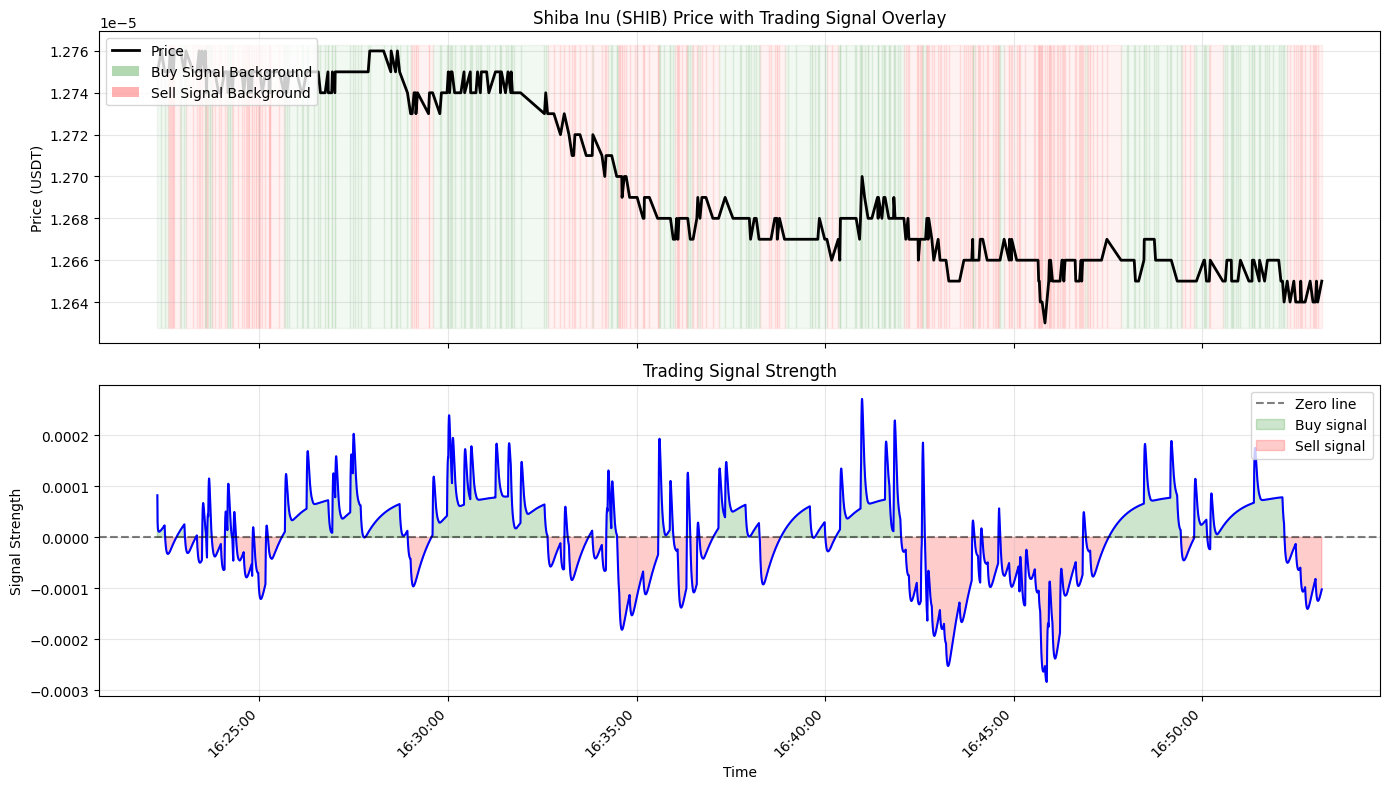

Shiba Inu (SHIB) Trading Signal Analysis:
  Buy signals (positive): 5545 (55.5%)
  Sell signals (negative/zero): 4455 (44.5%)
  Signal strength - Mean: 0.000000, Std: 0.000083
  Max signal: 0.000271, Min signal: -0.000283

=== TURBO TRADING ANALYSIS ===


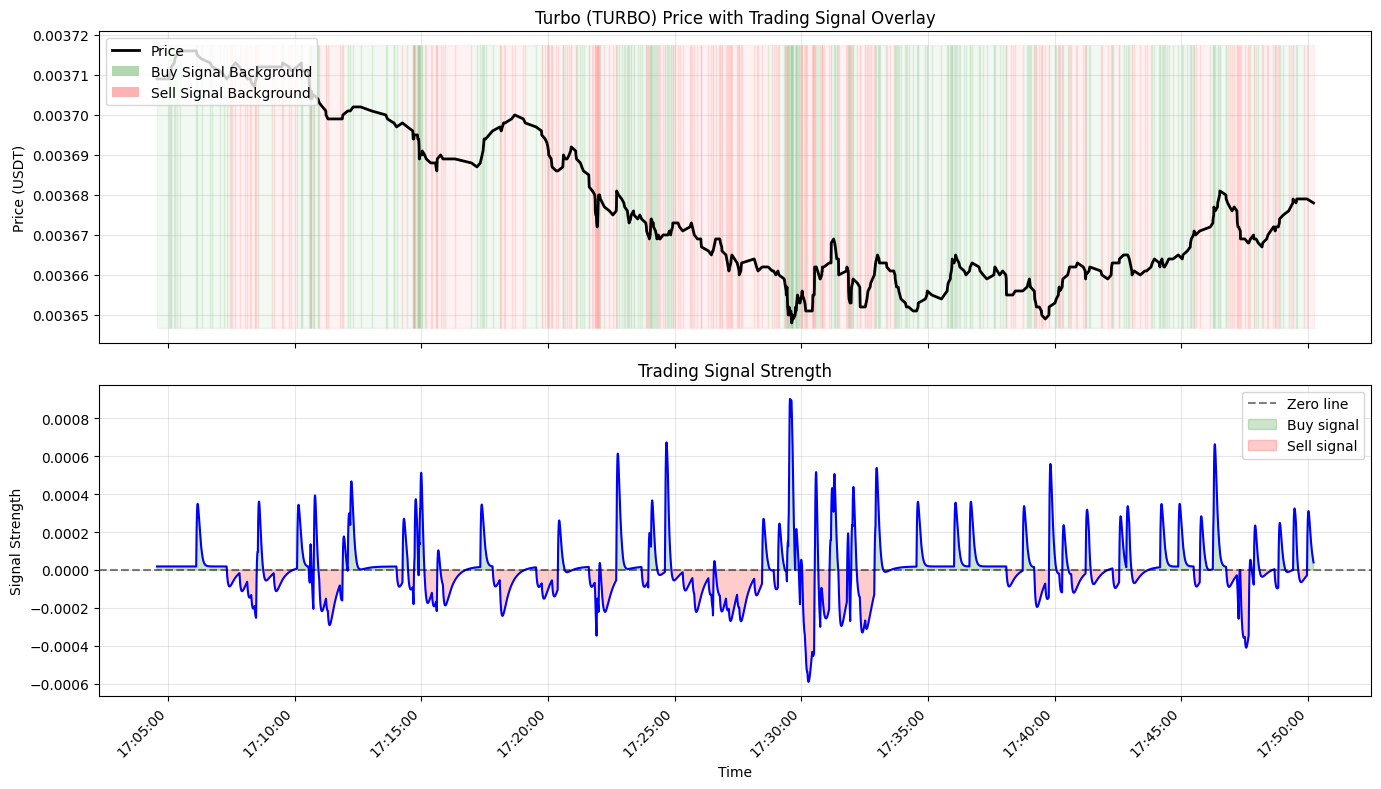

Turbo (TURBO) Trading Signal Analysis:
  Buy signals (positive): 5152 (51.5%)
  Sell signals (negative/zero): 4848 (48.5%)
  Signal strength - Mean: -0.000000, Std: 0.000160
  Max signal: 0.000902, Min signal: -0.000590



In [21]:
# Create enhanced price charts with trading signals overlay

def plot_price_with_signal(data, signal_values, time_array, currency_name):
    """
    Plot price data with color-coded background based on trading signal sign.
    
    Parameters:
    - data: DataFrame with price data
    - signal_values: Array of signal values (positive = buy, negative = sell)
    - time_array: Array of time values corresponding to signal
    - currency_name: Name of the currency for title
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Plot 1: Price with color-coded segments
    # We need to map signal times to price data times
    price_times = data["time"]
    price_values = data["open"]
    
    # Create signal for each price point by interpolating
    signal_interp = np.interp(
        (price_times - price_times.iloc[0]).dt.total_seconds(), 
        time_array, 
        signal_values
    )
    
    # Plot the price line in black
    ax1.plot(price_times, price_values, color='black', linewidth=2, zorder=3)
    
    # Create background color regions
    y_min, y_max = price_values.min(), price_values.max()
    y_range = y_max - y_min
    y_bottom = y_min - 0.02 * y_range  # Extend slightly below
    y_top = y_max + 0.02 * y_range     # Extend slightly above
    
    # Create segments for background coloring based on signal sign
    for i in range(len(price_values) - 1):
        current_signal = signal_interp[i]
        
        if current_signal > 0:
            color = 'green'  # Buy signal (positive)
            alpha = min(0.4, 0.05 + abs(current_signal) * 10)  # Background intensity based on signal strength
        else:
            color = 'red'    # Sell signal (negative or zero)
            alpha = min(0.4, 0.05 + abs(current_signal) * 10)
        
        # Fill background for this time segment
        ax1.fill_between(price_times.iloc[i:i+2], y_bottom, y_top, 
                        color=color, alpha=alpha, zorder=1)
    
    ax1.set_title(f"{currency_name} Price with Trading Signal Overlay")
    ax1.set_ylabel("Price (USDT)")
    ax1.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', lw=2, label='Price'),
        Patch(facecolor='green', alpha=0.3, label='Buy Signal Background'),
        Patch(facecolor='red', alpha=0.3, label='Sell Signal Background')
    ]
    ax1.legend(handles=legend_elements, loc='upper left')
    
    # Plot 2: Signal strength over time
    signal_time_datetime = price_times.iloc[0] + pd.to_timedelta(time_array, unit='s')
    ax2.plot(signal_time_datetime, signal_values, color='blue', linewidth=1.5)
    ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='Zero line')
    
    ax2.fill_between(signal_time_datetime, signal_values, 0, 
                     where=(signal_values > 0), color='green', alpha=0.2, label='Buy signal')
    ax2.fill_between(signal_time_datetime, signal_values, 0, 
                     where=(signal_values <= 0), color='red', alpha=0.2, label='Sell signal')
    
    ax2.set_title("Trading Signal Strength")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Signal Strength")
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    
    # Format x-axis
    fig.autofmt_xdate(rotation=45)
    date_form = mdates.DateFormatter('%H:%M:%S')
    ax2.xaxis.set_major_formatter(date_form)
    
    plt.tight_layout()
    plt.show()
    
    # Print signal statistics
    buy_signals = np.sum(signal_values > 0)
    sell_signals = np.sum(signal_values <= 0)
    
    print(f"{currency_name} Trading Signal Analysis:")
    print(f"  Buy signals (positive): {buy_signals} ({buy_signals/len(signal_values)*100:.1f}%)")
    print(f"  Sell signals (negative/zero): {sell_signals} ({sell_signals/len(signal_values)*100:.1f}%)")
    print(f"  Signal strength - Mean: {np.mean(signal_values):.6f}, Std: {np.std(signal_values):.6f}")
    print(f"  Max signal: {np.max(signal_values):.6f}, Min signal: {np.min(signal_values):.6f}")
    print()

# Apply to both currencies
print("=== SHIBA INU TRADING ANALYSIS ===")
plot_price_with_signal(data_shib, signal_diff_shib, t_plot_shib, "Shiba Inu (SHIB)")

print("=== TURBO TRADING ANALYSIS ===")
plot_price_with_signal(data_turbo, signal_diff_turbo, t_plot_turbo, "Turbo (TURBO)")

=== COMPARATIVE SIGNAL PERFORMANCE ANALYSIS ===

Metric               SHIB            TURBO          
--------------------------------------------------
Buy Signal Return           -0.0034%         0.0024%
Sell Signal Return          -0.0003%        -0.0058%
Neutral Return              -0.0018%        -0.0015%
Buy Signals                     207            297
Sell Signals                    228            266

=== SIGNAL EFFECTIVENESS ===
SHIB - Buy signals: Negative, Sell signals: Negative
TURBO - Buy signals: Positive, Sell signals: Positive



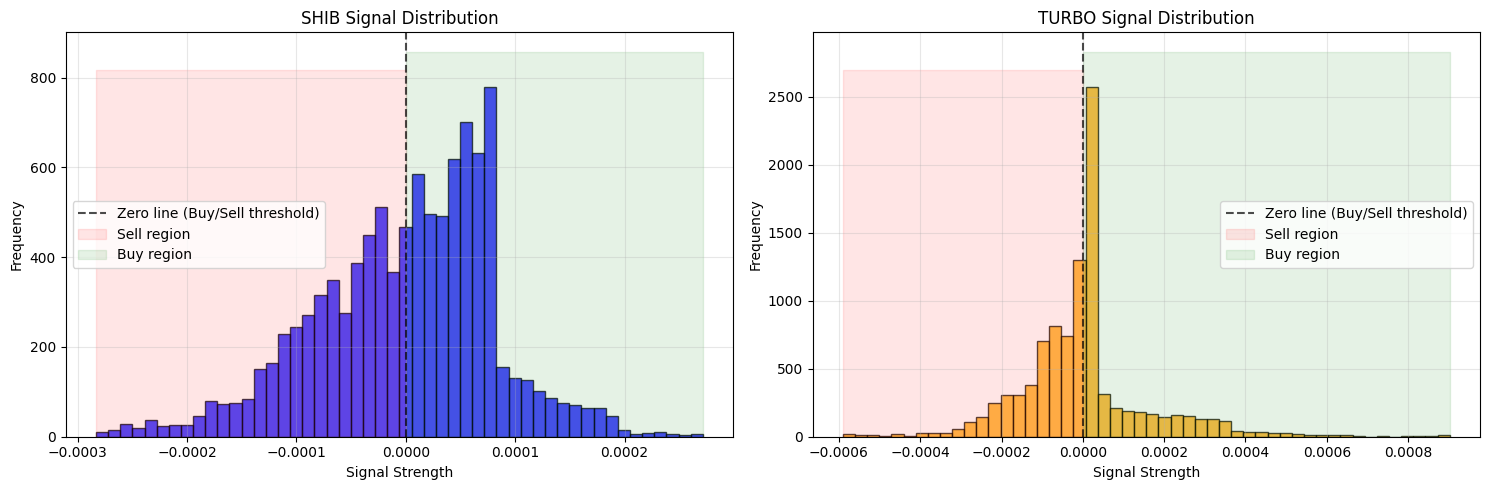

In [22]:
# Comparative analysis of both currencies
def analyze_signal_performance(data, signal_values, time_array, currency_name):
    """
    Analyze the performance correlation between signals and price movements.
    Uses signal sign (positive/negative) instead of thresholds.
    """
    # Interpolate signal to price timestamps
    price_times = data["time"]
    price_values = data["open"]
    
    signal_interp = np.interp(
        (price_times - price_times.iloc[0]).dt.total_seconds(), 
        time_array, 
        signal_values
    )
    
    # Calculate price returns
    price_returns = price_values.pct_change().fillna(0)
    
    # Since we removed thresholds, let's update this to use signal sign
    # Align arrays: price_returns has length n, signal_interp has length n
    # We need to use signal_interp[1:] to match price_returns[1:] (since first return is NaN->0)
    buy_mask = signal_interp[1:] > 0
    sell_mask = signal_interp[1:] <= 0
    
    # Calculate average returns for each signal type
    returns_subset = price_returns[1:]  # Skip first element to match signal length
    buy_returns = returns_subset[buy_mask].mean() if np.any(buy_mask) else 0
    sell_returns = returns_subset[sell_mask].mean() if np.any(sell_mask) else 0
    
    # For backward compatibility, we'll still report "neutral" as the overall mean
    neutral_returns = returns_subset.mean()
    
    return {
        'currency': currency_name,
        'buy_return': buy_returns,
        'sell_return': sell_returns,
        'neutral_return': neutral_returns,
        'signal_count': len(signal_values),
        'buy_signals': np.sum(buy_mask),
        'sell_signals': np.sum(sell_mask)
    }

# Analyze both currencies
shib_analysis = analyze_signal_performance(data_shib, signal_diff_shib, t_plot_shib, "SHIB")
turbo_analysis = analyze_signal_performance(data_turbo, signal_diff_turbo, t_plot_turbo, "TURBO")

# Create comparison table
print("=== COMPARATIVE SIGNAL PERFORMANCE ANALYSIS ===")
print()
print(f"{'Metric':<20} {'SHIB':<15} {'TURBO':<15}")
print("-" * 50)
print(f"{'Buy Signal Return':<20} {shib_analysis['buy_return']*100:>14.4f}% {turbo_analysis['buy_return']*100:>14.4f}%")
print(f"{'Sell Signal Return':<20} {shib_analysis['sell_return']*100:>14.4f}% {turbo_analysis['sell_return']*100:>14.4f}%")
print(f"{'Neutral Return':<20} {shib_analysis['neutral_return']*100:>14.4f}% {turbo_analysis['neutral_return']*100:>14.4f}%")
print(f"{'Buy Signals':<20} {shib_analysis['buy_signals']:>14} {turbo_analysis['buy_signals']:>14}")
print(f"{'Sell Signals':<20} {shib_analysis['sell_signals']:>14} {turbo_analysis['sell_signals']:>14}")
print()

# Signal effectiveness analysis
buy_effectiveness_shib = "Positive" if shib_analysis['buy_return'] > shib_analysis['neutral_return'] else "Negative"
sell_effectiveness_shib = "Positive" if shib_analysis['sell_return'] < shib_analysis['neutral_return'] else "Negative"

buy_effectiveness_turbo = "Positive" if turbo_analysis['buy_return'] > turbo_analysis['neutral_return'] else "Negative"
sell_effectiveness_turbo = "Positive" if turbo_analysis['sell_return'] < turbo_analysis['neutral_return'] else "Negative"

print("=== SIGNAL EFFECTIVENESS ===")
print(f"SHIB - Buy signals: {buy_effectiveness_shib}, Sell signals: {sell_effectiveness_shib}")
print(f"TURBO - Buy signals: {buy_effectiveness_turbo}, Sell signals: {sell_effectiveness_turbo}")
print()

# Create visualization of signal distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# SHIB signal distribution
axes[0].hist(signal_diff_shib, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Zero line (Buy/Sell threshold)')
axes[0].fill_between(np.linspace(signal_diff_shib.min(), 0, 10), 0, axes[0].get_ylim()[1], 
                     color='red', alpha=0.1, label='Sell region')
axes[0].fill_between(np.linspace(0, signal_diff_shib.max(), 10), 0, axes[0].get_ylim()[1], 
                     color='green', alpha=0.1, label='Buy region')
axes[0].set_title('SHIB Signal Distribution')
axes[0].set_xlabel('Signal Strength')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# TURBO signal distribution
axes[1].hist(signal_diff_turbo, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.7, label='Zero line (Buy/Sell threshold)')
axes[1].fill_between(np.linspace(signal_diff_turbo.min(), 0, 10), 0, axes[1].get_ylim()[1], 
                     color='red', alpha=0.1, label='Sell region')
axes[1].fill_between(np.linspace(0, signal_diff_turbo.max(), 10), 0, axes[1].get_ylim()[1], 
                     color='green', alpha=0.1, label='Buy region')
axes[1].set_title('TURBO Signal Distribution')
axes[1].set_xlabel('Signal Strength')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

*Remarks:*

- The assumption that "sales imply more sales and purchases imply more purchases" is a basic assumption that can be false or not sufficient to give a real edge.
- We interpret the data under the assumption that price growth is a consequence of a purchase, and price decrease follows a sale. This is misleading because the traded price is defined by the midpoint between the highest buyer and the lowest seller. It depends on the order book and does not directly reflect traded volumes. For large liquid stocks this may approximate the "true" market price, but for small illiquid stocks the price can shift drastically with very small trades.
- Ignoring **spread** is problematic: when the spread is wide, a single trade can move the price significantly, while with a tight spread, many trades may occur without meaningful price movement.
- Ignoring **slippage** is also problematic: the difference between the expected execution price and the actual execution price can dramatically reduce or even destroy apparent profitability when backtesting or simulating strategies.
- Other processes and features are needed to describe the complex interactions between sales, purchases, liquidity, and the order book, such as the imbalance between bid and ask, depth of the book, and market impact.
- Exogenous shocks (such as news or announcements) can trigger bursts of activity that look like self-excitation but are not generated endogenously by the order flow.
- Intraday seasonality (open, lunch, close) must also be modeled, otherwise the Hawkes model will falsely attribute clustering of events to self-excitation.


## References

- [1] **Laub, P. J.**, **Lee, Y.**, **Pollett, P. K.**, & **Taimre, T.** (2024).
  *Hawkes Models and Their Applications*.
  [arXiv:2405.10527](https://arxiv.org/html/2405.10527v1).
  arXiv preprint.

- [2] *HawkesPyLib* (https://pypi.org/project/HawkesPyLib/)